# GIS Data Science Assignment: Climate Change Analysis in Tanzania

In this assignment, you will analyze climate change patterns in Tanzania using GIS data. You will work with spatial data to understand, visualize, and analyze climate trends across different regions of Tanzania.

## Setup
First, let's import the necessary libraries:

In [1]:
# Run this cell to install any missing dependencies
!pip install geopandas matplotlib numpy pandas seaborn folium mapclassify xarray rasterio contextily

  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached matplotlib-3.10.1-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached numpy-2.2.3-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached folium-0.19.5-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached mapclassify-2.8.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached xarray-2025.1.2-py3-none-any.whl.metadata (11 kB)
  Using cached rasterio-1.4.3-cp311-cp311-win_amd64.whl.metadata (9.4 kB)
  Using cached contextily-1.6.2-py3-none-any.whl.metadata (2.9 kB)
  Using cached pyogrio-0.10.0-cp311-cp311-win_amd64.whl.metadata (5.6 kB)
  Using cached pyproj-3.7.1-cp311-cp311-win_amd64.whl.metadata (31 kB)
  Using cached shapely-2.0.7-cp311-cp311-win_amd64.whl.metadata (7.1 kB)
  Using cached contourpy-1.3.1-cp311-cp311-win_amd64.whl.metadata (5.4 kB)
  Using cached cy

In [2]:
# Import necessary libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os
from matplotlib.colors import ListedColormap
import contextily as ctx

# Set plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(style="whitegrid")

## Part 1: GIS Data Basics

### Task 1.1: Load the Tanzania Shapefile
Load the Tanzania administrative boundaries shapefile and examine its structure.



In [12]:
# TODO: Load the Tanzania shapefile
tz_shapefile = gpd.read_file("data/tanzania_regions.shp")  # Replace with the actual path
print(tz_shapefile.head())
# Hint: Use gpd.read_file() to load the shapefile

# Function to display basic information about a GeoDataFrame
def describe_geodataframe(gdf):
   
    info = {
        'crs': gdf.crs,  # Get the coordinate reference system
        'geometry_type': gdf.geom_type.unique().tolist(),  # Get geometry types
        'num_features': len(gdf),  # Number of features
        'attributes': gdf.columns.tolist(),  # Attribute column names
        'total_area_km2': gdf.to_crs(epsg=21037).geometry.area.sum() / 1e6,  # Convert to sq km
        'bounds': gdf.total_bounds  # Bounding box
    }
    return info

# Call the function with your loaded shapefile
tz_info = describe_geodataframe(tz_shapefile)

# Print the results
for key, value in tz_info.items():
    print(f"{key}: {value}")

      REGION_NAM REGION_COD                ZONE  LAND_AREA_  POPULATION  \
0         Arusha         AR            Northern     8238.33      523949   
1  Dar es Salaam         DS             Eastern     7765.76      311157   
2         Dodoma         DO             Central    10271.91      784652   
3          Geita         GE                Lake    11836.41      565591   
4         Iringa         IR  Southern Highlands    18649.73      214091   

   POP_DENSIT  ELEVATION_  DIST_TO_CO  \
0       63.60       920.2       469.3   
1       40.07      1298.9       257.1   
2       76.39      1790.4       416.6   
3       47.78      1440.9       460.9   
4       11.48       476.1        82.6   

                                            geometry  
0  POLYGON ((34.45632 -2.43802, 34.18813 -2.98755...  
1  POLYGON ((38.70825 -1.57788, 38.50566 -2.00984...  
2  POLYGON ((36.45921 -11.0355, 36.2375 -11.44126...  
3  POLYGON ((32.644 -7.58939, 32.52306 -8.1697, 3...  
4  POLYGON ((32.18459 -9.54

### Task 1.2: Understand Coordinate Reference Systems
Explain the current CRS and reproject the data to a suitable projection for Tanzania.

In [20]:


# Reproject to EPSG:21037 (Arc 1960 / UTM Zone 37S - Suitable for Tanzania)
tz_projected = tz_shapefile.to_crs(epsg=21037)
print("New CRS:", tz_projected.crs)

# Function to Compare Projections
def compare_projections(original_gdf, reprojected_gdf):
    """Compare the original and reprojected GeoDataFrames.
    
    Parameters:
    original_gdf (GeoDataFrame): The original GeoDataFrame (geographic CRS)
    reprojected_gdf (GeoDataFrame): The reprojected GeoDataFrame (projected CRS)
    
    Returns:
    dict: A dictionary containing comparison metrics
    """
    # Convert original to projected CRS before measuring area
    original_projected = original_gdf.to_crs(epsg=21037)

    # Compute areas in square kilometers
    original_area = original_projected.geometry.area.sum() / 1e6  # Convert m² to km²
    new_area = reprojected_gdf.geometry.area.sum() / 1e6  # Already in projected CRS

    # Compute percentage difference
    percent_difference = ((new_area - original_area) / original_area) * 100 if original_area else None

    comparison = {
        'original_crs': original_gdf.crs,  
        'new_crs': reprojected_gdf.crs,  
        'original_area_km2': original_area,  # Corrected area in square kilometers
        'new_area_km2': new_area,  
        'percent_difference': percent_difference  
    }
    
    return comparison

# Call the function
projection_comparison = compare_projections(tz_shapefile, tz_projected)

# Print the results
for key, value in projection_comparison.items():
    print(f"{key}: {value}")


New CRS: EPSG:21037
original_crs: EPSG:4326
new_crs: EPSG:21037
original_area_km2: 334462.65500737564
new_area_km2: 334462.65500737564
percent_difference: 0.0


## Part 2: Data Loading and Processing

### Task 2.1: Load Climate Data
Load the provided climate data for Tanzania and examine its structure.

In [22]:

# Load the climate data CSV file
climate_data = pd.read_csv("data/tanzania_annual_climate_data.csv")  # Replace with actual file path

# Display first few rows and basic statistics
print(climate_data.head())  # Preview data
print(climate_data.info())  # Check data types and missing values
print(climate_data.describe())  # Get summary statistics

# Function to check missing values
def check_missing_values(df):
    """Check for missing values in a DataFrame.
    
    Parameters:
    df (DataFrame): The climate dataset
    
    Returns:
    DataFrame: A summary of missing values per column
    """
    missing_summary = df.isnull().sum()  # Count missing values
    missing_percentage = (missing_summary / len(df)) * 100  # Calculate percentage
    return pd.DataFrame({'Missing Values': missing_summary, 'Percentage (%)': missing_percentage})

# Call the function
missing_summary = check_missing_values(climate_data)

# Print the results
print(missing_summary)


  REGION_CODE REGION_NAME  YEAR      ZONE  ANNUAL_AVG_TEMP_C  MAX_TEMP_C  \
0          AR      Arusha  2000  Northern              21.71       26.60   
1          AR      Arusha  2001  Northern              22.45       27.81   
2          AR      Arusha  2002  Northern              22.81       27.30   
3          AR      Arusha  2003  Northern              21.38       25.77   
4          AR      Arusha  2004  Northern              21.67       26.89   

   MIN_TEMP_C  ANNUAL_PRECIP_MM  ANNUAL_RAIN_DAYS  ANNUAL_HEAVY_RAIN_DAYS  \
0       16.99            6918.2               107                      21   
1       17.78            6333.0               104                      15   
2       17.74           10795.2               144                      41   
3       16.39            5592.0                62                      10   
4       16.57           10407.2               150                      39   

   ANNUAL_DROUGHT_INDEX  ELEVATION_M  DISTANCE_TO_COAST_KM  
0              0.10

### Task 2.2: Join Climate Data with Spatial Data
Merge the climate data with the Tanzania shapefile based on a common identifier.

In [26]:
# TODO: Identify the common field between the climate data and the shapefile
# Hint: Look for a region/district identifier in both datasets
print(tz_shapefile.columns)  # Check available fields in the shapefile
print("climate heads",climate_data.columns)  # Check available fields in the climate data

# Identify the common field: 'REGION_NAM' in shapefile, 'REGION_NAME' in climate data
# Standardize the column names
tz_shapefile.rename(columns={'REGION_NAM': 'REGION_NAME'}, inplace=True)
climate_data['REGION_NAME'] = climate_data['REGION_NAME'].str.upper()
tz_shapefile['REGION_NAME'] = tz_shapefile['REGION_NAME'].str.upper()

# Join the climate data with the shapefile
tz_climate = tz_shapefile.merge(climate_data, on='REGION_NAME', how='left')

# Verify the join was successful by checking the shape and contents of the result
def verify_join(original_gdf, joined_gdf, climate_df):
    """Verify that the join between spatial and climate data was successful."""
    
    verification = {
        'original_features': len(original_gdf),
        'joined_features': len(joined_gdf),
        'climate_records': len(climate_df),
        'joined_columns': list(joined_gdf.columns),
        'is_successful': len(joined_gdf) > 0 and 'ANNUAL_AVG_TEMP_C' in joined_gdf.columns
    }
    return verification

join_verification = verify_join(tz_shapefile, tz_climate, climate_data)
print(join_verification)

Index(['REGION_NAM', 'REGION_COD', 'ZONE', 'LAND_AREA_', 'POPULATION',
       'POP_DENSIT', 'ELEVATION_', 'DIST_TO_CO', 'geometry'],
      dtype='object')
climate heads Index(['REGION_CODE', 'REGION_NAME', 'YEAR', 'ZONE', 'ANNUAL_AVG_TEMP_C',
       'MAX_TEMP_C', 'MIN_TEMP_C', 'ANNUAL_PRECIP_MM', 'ANNUAL_RAIN_DAYS',
       'ANNUAL_HEAVY_RAIN_DAYS', 'ANNUAL_DROUGHT_INDEX', 'ELEVATION_M',
       'DISTANCE_TO_COAST_KM'],
      dtype='object')
{'original_features': 31, 'joined_features': 744, 'climate_records': 744, 'joined_columns': ['REGION_NAME', 'REGION_COD', 'ZONE_x', 'LAND_AREA_', 'POPULATION', 'POP_DENSIT', 'ELEVATION_', 'DIST_TO_CO', 'geometry', 'REGION_CODE', 'YEAR', 'ZONE_y', 'ANNUAL_AVG_TEMP_C', 'MAX_TEMP_C', 'MIN_TEMP_C', 'ANNUAL_PRECIP_MM', 'ANNUAL_RAIN_DAYS', 'ANNUAL_HEAVY_RAIN_DAYS', 'ANNUAL_DROUGHT_INDEX', 'ELEVATION_M', 'DISTANCE_TO_COAST_KM'], 'is_successful': True}


## Part 3: Data Visualization

### Task 3.1: Create a Choropleth Map
Create a choropleth map showing average temperature across Tanzania regions.

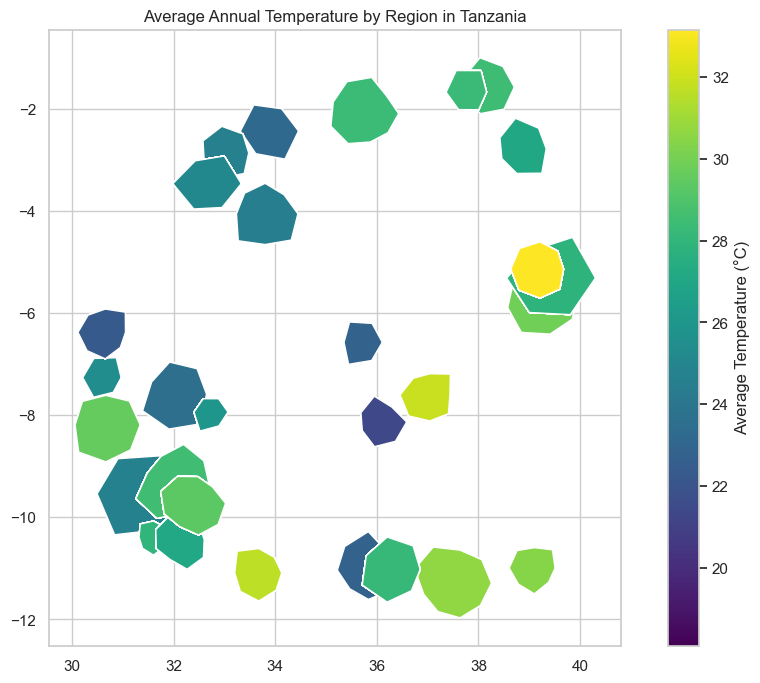

In [31]:
# TODO: Create a choropleth map of average temperature by region
# Hint: Use the .plot() method with the column parameter
def create_choropleth(gdf, column, title, cmap='viridis', figsize=(12, 8)):
    """Create a choropleth map for a GeoDataFrame.
    
    Parameters:
    gdf (GeoDataFrame): The GeoDataFrame to plot
    column (str): The column to use for coloring
    title (str): The title of the map
    cmap (str or Colormap): The colormap to use
    figsize (tuple): The figure size
    
    Returns:
    matplotlib.figure.Figure: The created figure
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    gdf.plot(column=column, ax=ax, legend=True, cmap=cmap, legend_kwds={'label': "Average Temperature (°C)"})
    ax.set_title(title)
    return fig

temp_map = create_choropleth(tz_climate, 'ANNUAL_AVG_TEMP_C', 'Average Annual Temperature by Region in Tanzania')
plt.show() # Display the plot

### Task 3.2: Create a Time Series Visualization
Create a time series visualization showing temperature trends over time for selected regions.

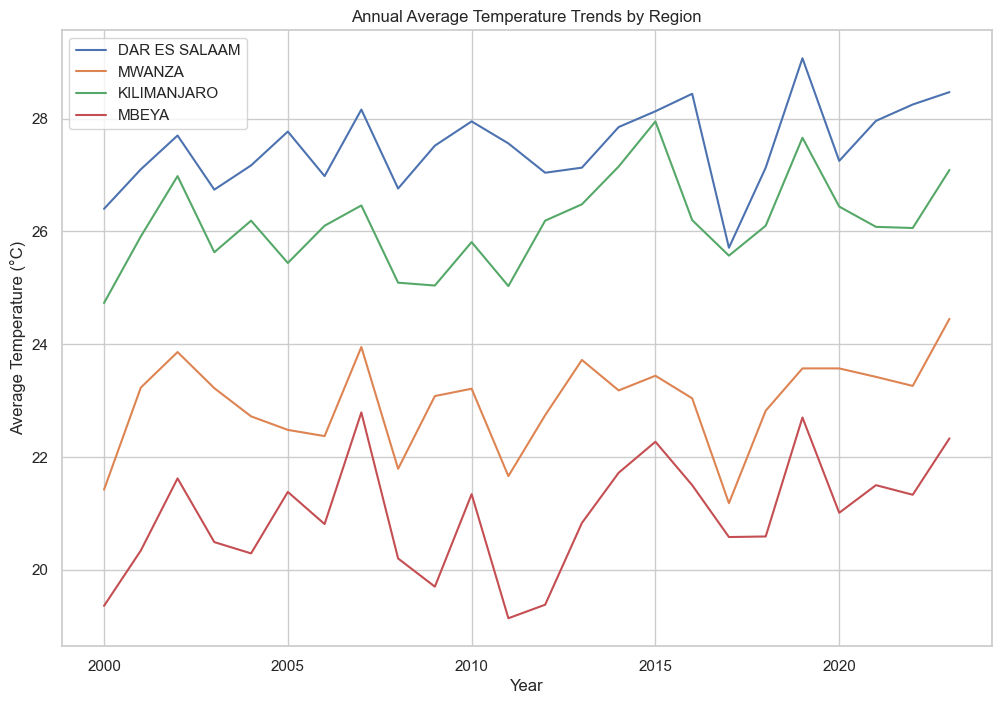

In [32]:
# TODO: Select a few representative regions for the time series
# Hint: Choose regions from different parts of the country
selected_regions = ['DAR ES SALAAM', 'MWANZA', 'KILIMANJARO', 'MBEYA'] # Example regions

# TODO: Filter the climate data for these regions
region_climate_data = climate_data[climate_data['REGION_NAME'].str.upper().isin(selected_regions)]

# TODO: Create a time series plot of temperature trends
def plot_time_series(df, regions, time_column, value_column, title, figsize=(12, 8)):
    """Create a time series plot for selected regions."""
    
    fig, ax = plt.subplots(figsize=figsize)
    for region in regions:
        region_data = df[df['REGION_NAME'].str.upper() == region]
        ax.plot(region_data[time_column], region_data[value_column], label=region)
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Average Temperature (°C)')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    return fig

temp_time_series = plot_time_series(region_climate_data, selected_regions, 'YEAR', 'ANNUAL_AVG_TEMP_C', 'Annual Average Temperature Trends by Region')
plt.show()

### Task 3.3: Create an Interactive Map
Create an interactive map showing climate data using Folium.

In [33]:
# TODO: Convert the projected GeoDataFrame to WGS84 for use with Folium
tz_wgs84 = tz_climate.to_crs(epsg=4326) # WGS84

# TODO: Create an interactive map using Folium
def create_interactive_map(gdf, column, popup_columns, title, center=None, zoom_start=6):
    """Create an interactive map using Folium."""
    
    if center is None:
        center = [gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()] # Center on the mean coordinates if not specified.

    m = folium.Map(location=center, zoom_start=zoom_start, tiles='cartodbpositron')

    folium.Choropleth(
        geo_data=gdf.__geo_interface__,
        name='choropleth',
        data=gdf,
        columns=['REGION_NAME', column],
        key_on='feature.properties.REGION_NAME',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=title,
    ).add_to(m)

    folium.GeoJson(
        gdf,
        name='regions',
        popup=folium.GeoJsonPopup(fields=popup_columns),
    ).add_to(m)

    return m

interactive_map = create_interactive_map(
    tz_wgs84,
    'ANNUAL_AVG_TEMP_C',
    ['REGION_NAME', 'ANNUAL_AVG_TEMP_C', 'ANNUAL_PRECIP_MM'],
    'Average Annual Temperature by Region in Tanzania'
)

# Display the map
interactive_map

C:\Users\tronix\AppData\Local\Temp\ipykernel_13752\1630914025.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()] # Center on the mean coordinates if not specified.


## Part 4: Climate Change EDA

### Task 4.1: Analyze Temperature Trends
Analyze the trends in temperature across Tanzania over time.

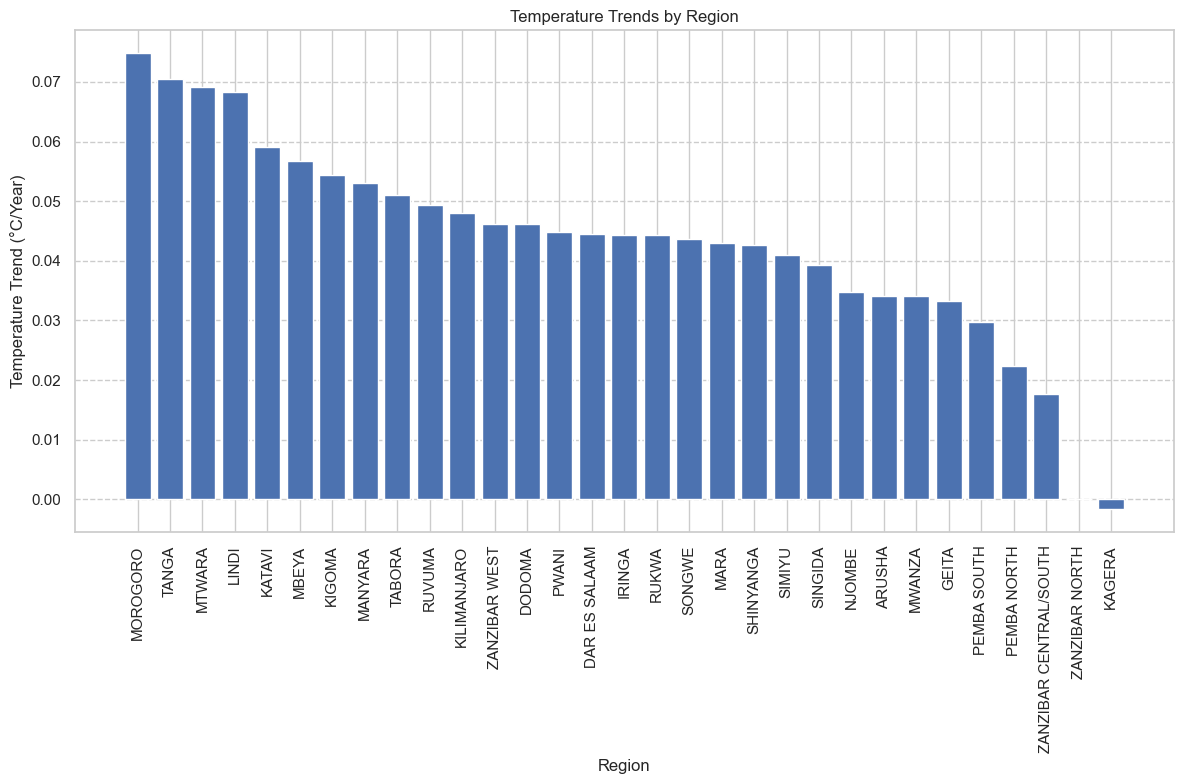

In [35]:
from sklearn.linear_model import LinearRegression
# TODO: Calculate temperature trends for each region
def calculate_temperature_trends(df, region_column, year_column, temp_column):
    """Calculate temperature trends for each region."""
    
    trends = []
    for region in df[region_column].unique():
        region_data = df[df[region_column] == region]
        years = region_data[year_column].values.reshape(-1, 1)
        temps = region_data[temp_column].values
        
        if len(years) > 1: # Ensure there are enough data points
            model = LinearRegression()
            model.fit(years, temps)
            slope = model.coef_[0]
            intercept = model.intercept_
            trends.append({'Region': region, 'Trend': slope, 'Intercept': intercept})
        else:
            trends.append({'Region': region, 'Trend': np.nan, 'Intercept': np.nan}) # Handle cases with insufficient data

    return pd.DataFrame(trends)

temp_trends = calculate_temperature_trends(climate_data, 'REGION_NAME', 'YEAR', 'ANNUAL_AVG_TEMP_C')

# TODO: Visualize the temperature trends
def plot_temperature_trends(trends_df, region_column, trend_column, title, figsize=(12, 8)):
    """Plot temperature trends by region."""
    
    trends_df = trends_df.sort_values(by=trend_column, ascending=False) # Sort for better visualization
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(trends_df[region_column], trends_df[trend_column])
    
    ax.set_xlabel('Region')
    ax.set_ylabel('Temperature Trend (°C/Year)')
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=90) # Rotate x-axis labels for readability
    ax.grid(axis='y', linestyle='--')
    
    return fig

trends_plot = plot_temperature_trends(temp_trends, 'Region', 'Trend', 'Temperature Trends by Region')
plt.tight_layout() # Improves plot layout
plt.show()

### Task 4.2: Identify Climate Change Hotspots
Identify regions in Tanzania that are experiencing the most significant climate change.

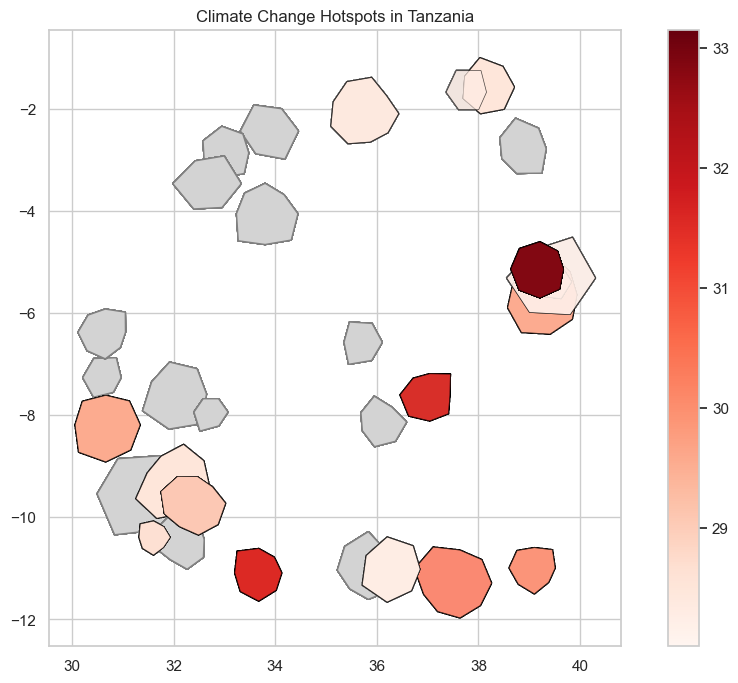

In [36]:
# TODO: Define criteria for climate change hotspots
# Hint: Consider temperature trends, precipitation changes, extreme weather events, etc.

# TODO: Implement a function to identify hotspots based on your criteria
def identify_hotspots(climate_gdf, criteria_columns, threshold_values):
    """Identify climate change hotspots based on specified criteria.
    
    Parameters:
    climate_gdf (GeoDataFrame): The GeoDataFrame containing climate and spatial data
    criteria_columns (list): The columns to use as criteria
    threshold_values (dict): A dictionary mapping criteria columns to threshold values
    
    Returns:
    GeoDataFrame: A GeoDataFrame containing only the hotspot regions
    """
    # Create a boolean mask for each criterion
    masks = []
    for column in criteria_columns:
        if column in threshold_values:
            threshold = threshold_values[column]
            masks.append(climate_gdf[column] > threshold)  # Example: temperature above threshold
        else:
            print(f"Warning: No threshold specified for column '{column}'. Skipping.")
    
    # Combine the masks using logical AND
    if masks:
        combined_mask = masks[0]
        for mask in masks[1:]:
            combined_mask = combined_mask & mask
        
        # Filter the GeoDataFrame based on the combined mask
        hotspots = climate_gdf[combined_mask]
        return hotspots
    else:
        print("No valid criteria specified. Returning the original GeoDataFrame.")
        return climate_gdf

# Example usage (you'll need to replace with your actual criteria and thresholds)
criteria_columns = ['ANNUAL_AVG_TEMP_C', 'ANNUAL_PRECIP_MM']
threshold_values = {'ANNUAL_AVG_TEMP_C': 28, 'ANNUAL_PRECIP_MM': 1200}
hotspots = identify_hotspots(tz_climate, criteria_columns, threshold_values)


# TODO: Visualize the identified hotspots
def visualize_hotspots(hotspots_gdf, base_gdf, column, title, cmap='Reds'):
    """Visualize the identified climate hotspots on a map."""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    base_gdf.plot(ax=ax, color='lightgray', edgecolor='gray')  # Plot the base map first
    hotspots_gdf.plot(column=column, ax=ax, legend=True, cmap=cmap, edgecolor='black', linewidth=0.5, alpha=0.7)
    ax.set_title(title)
    plt.show()

if hotspots is not None:
    visualize_hotspots(hotspots, tz_climate, 'ANNUAL_AVG_TEMP_C', 'Climate Change Hotspots in Tanzania')
    hotspot_map = None  # Placeholder for an interactive map (implementation needed)
else:
    print("No hotspots identified. Please review your criteria and thresholds.")


### Task 4.3: Regional Climate Variation Analysis
Analyze how climate variables vary across different regions of Tanzania.

                       ANNUAL_AVG_TEMP_C                          \
                                    mean       std    min    max   
REGION_NAME                                                        
ARUSHA                         22.330000  0.725121  21.12  23.55   
DAR ES SALAAM                  27.510000  0.750710  25.71  29.07   
DODOMA                         22.178333  0.776714  20.57  23.24   
GEITA                          22.882083  0.716895  21.56  24.20   
IRINGA                         23.940833  0.700006  22.53  25.01   
KAGERA                         25.272500  0.658854  24.05  26.43   
KATAVI                         28.757917  0.774445  26.87  30.33   
KIGOMA                         27.724167  0.790871  26.22  29.00   
KILIMANJARO                    26.140833  0.815981  24.73  27.95   
LINDI                          30.700000  0.900140  29.13  32.95   
MANYARA                        23.671250  0.792384  22.00  24.91   
MARA                           24.607083  0.7344

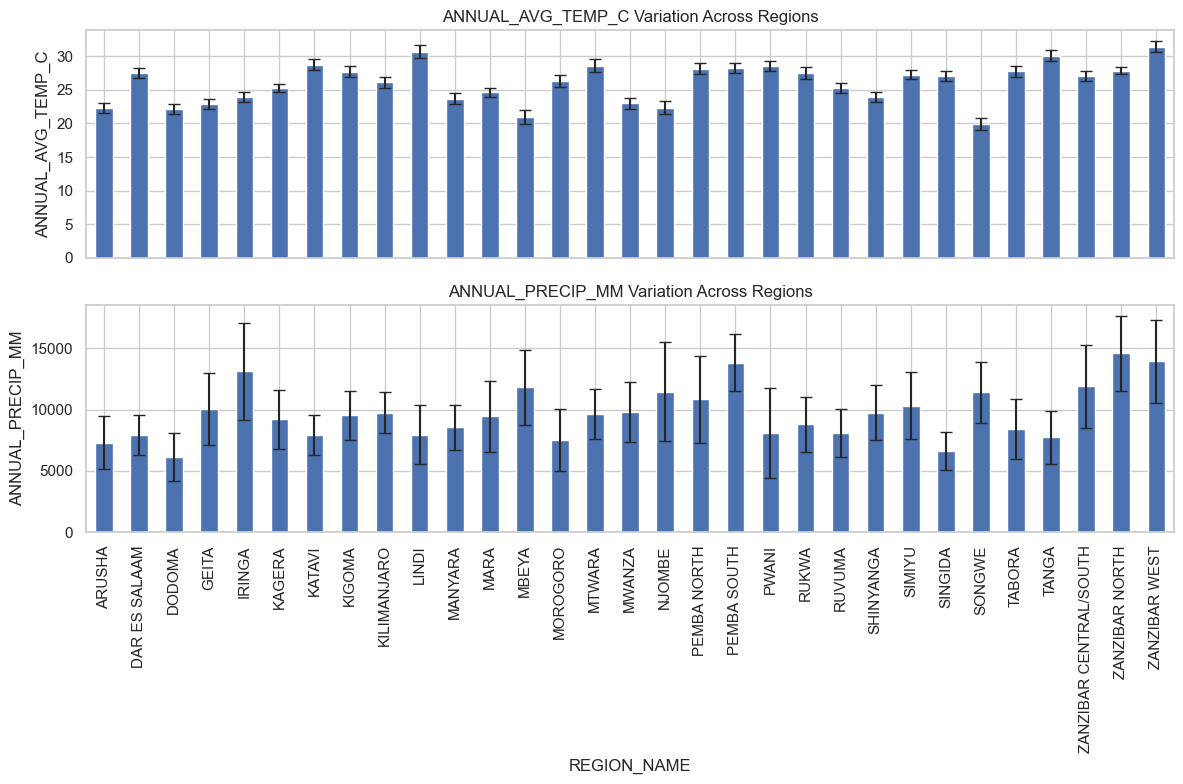

In [37]:
# TODO: Calculate regional statistics for climate variables
def calculate_regional_stats(gdf, region_column, climate_columns):
    """Calculate statistics for climate variables by region.
    Parameters:
    gdf (GeoDataFrame): The GeoDataFrame containing climate and spatial data
    region_column (str): The column containing region identifiers
    climate_columns (list): The columns containing climate variables
    Returns:
    DataFrame: A DataFrame containing statistics for each region and climate variable
    """
    regional_stats = gdf.groupby(region_column)[climate_columns].agg(['mean', 'std', 'min', 'max'])
    return regional_stats

regional_stats = calculate_regional_stats(tz_climate, 'REGION_NAME', ['ANNUAL_AVG_TEMP_C', 'ANNUAL_PRECIP_MM'])
print(regional_stats)

# TODO: Create comparative visualizations of regional climate variations
import matplotlib.pyplot as plt
def plot_regional_variations(stats_df, region_column, climate_columns, title, figsize=(12, 8)):
    """Create visualizations comparing regional climate variations."""
    fig, axes = plt.subplots(len(climate_columns), 1, figsize=figsize, sharex=True)
    for i, col in enumerate(climate_columns):
        stats_df[col]['mean'].plot(kind='bar', ax=axes[i], yerr=stats_df[col]['std'], capsize=4)
        axes[i].set_ylabel(col)
        axes[i].set_title(f'{col} Variation Across Regions')
    plt.tight_layout()
    plt.show()
    return fig

variations_plot = plot_regional_variations(regional_stats, 'REGION_NAME', ['ANNUAL_AVG_TEMP_C', 'ANNUAL_PRECIP_MM'], 'Regional Climate Variations')


## Conclusion

### Task 5: Summarize Findings
Summarize your key findings from the climate change analysis.

**TODO: Write a summary of your findings here.**

Your summary should include:
1. Key observations about temperature trends
2. Identified climate change hotspots
3. Notable regional variations
4. Potential implications for Tanzania
5. Recommendations for further analysis